In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from time import time
import torch
import torchode as tODE

import dataset as ds
import plotting as pl

### 1. Generate training data

In [3]:
# Inputs
num_training_samples = 11
state_dimension = 5
forcing_magnitudes = np.linspace(1.0, 8.0, num_training_samples)
times = np.arange(0.0, 30.0, 0.01)

# Generate data
states = []
for forcing_magnitude in forcing_magnitudes:
    all_states = ds.run_dynamics(
        times=times,
        state_dimension=state_dimension,
        forcing_magnitude=forcing_magnitude,
    )
    states.append(all_states.T)

11
(5, 3000)


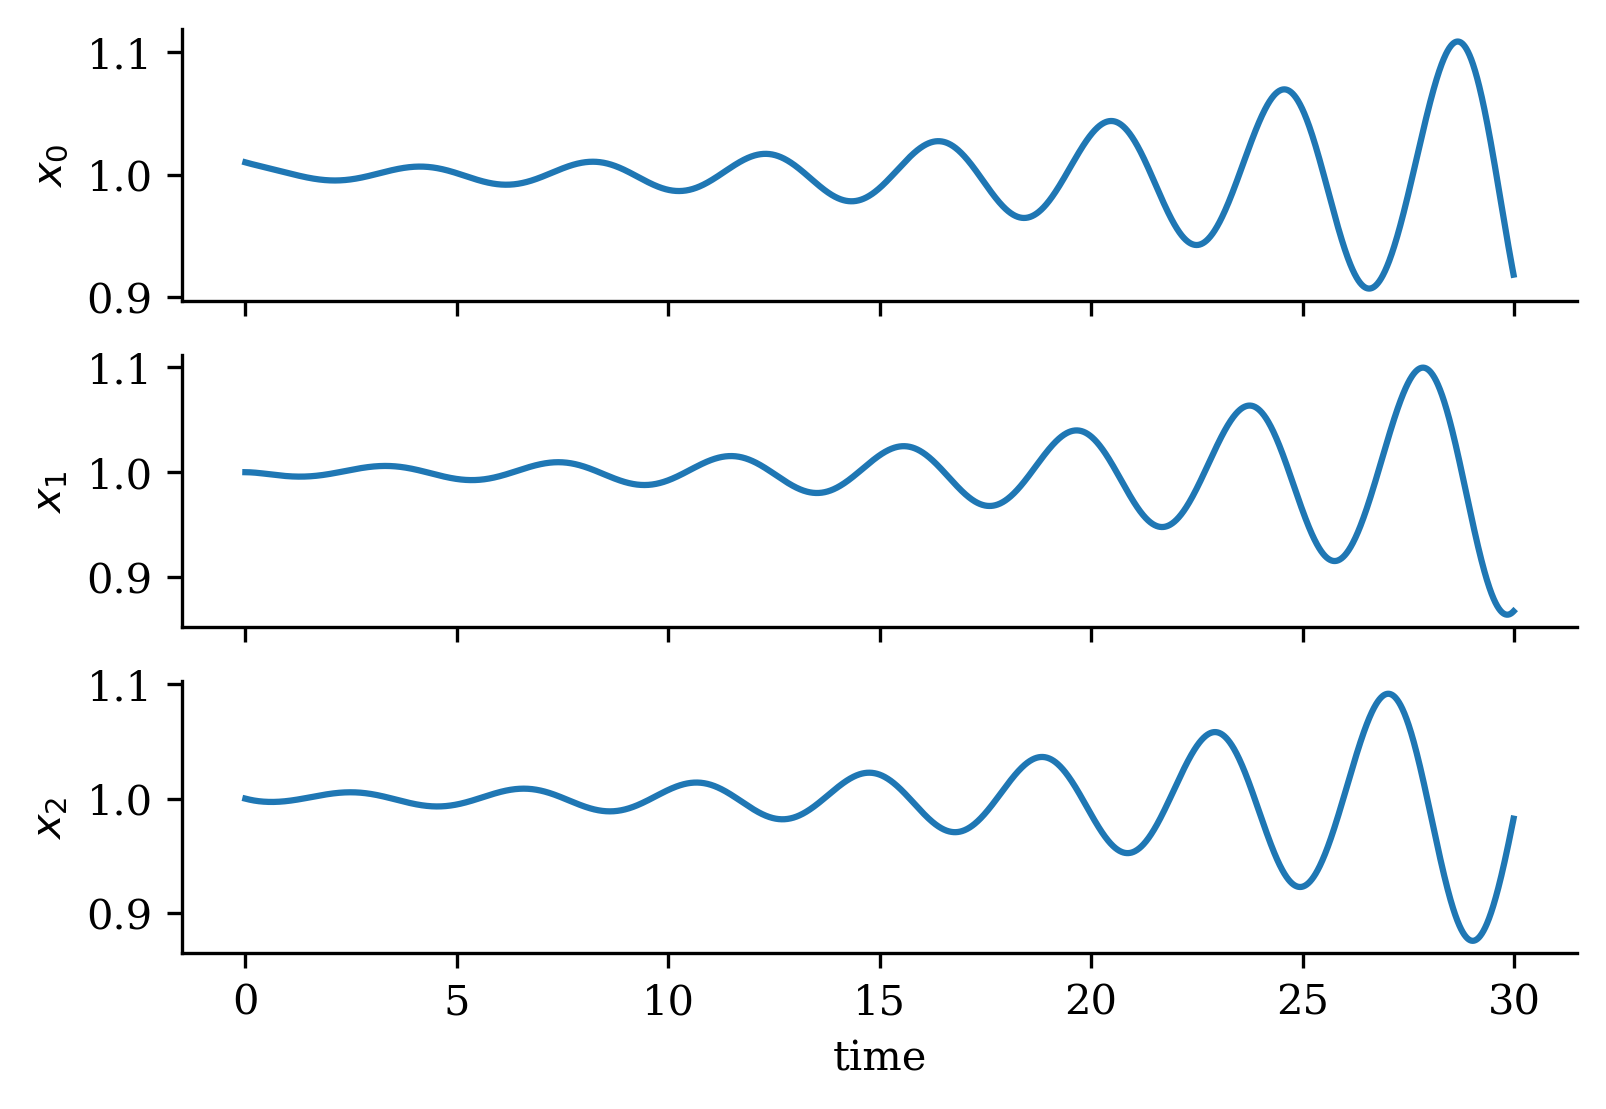

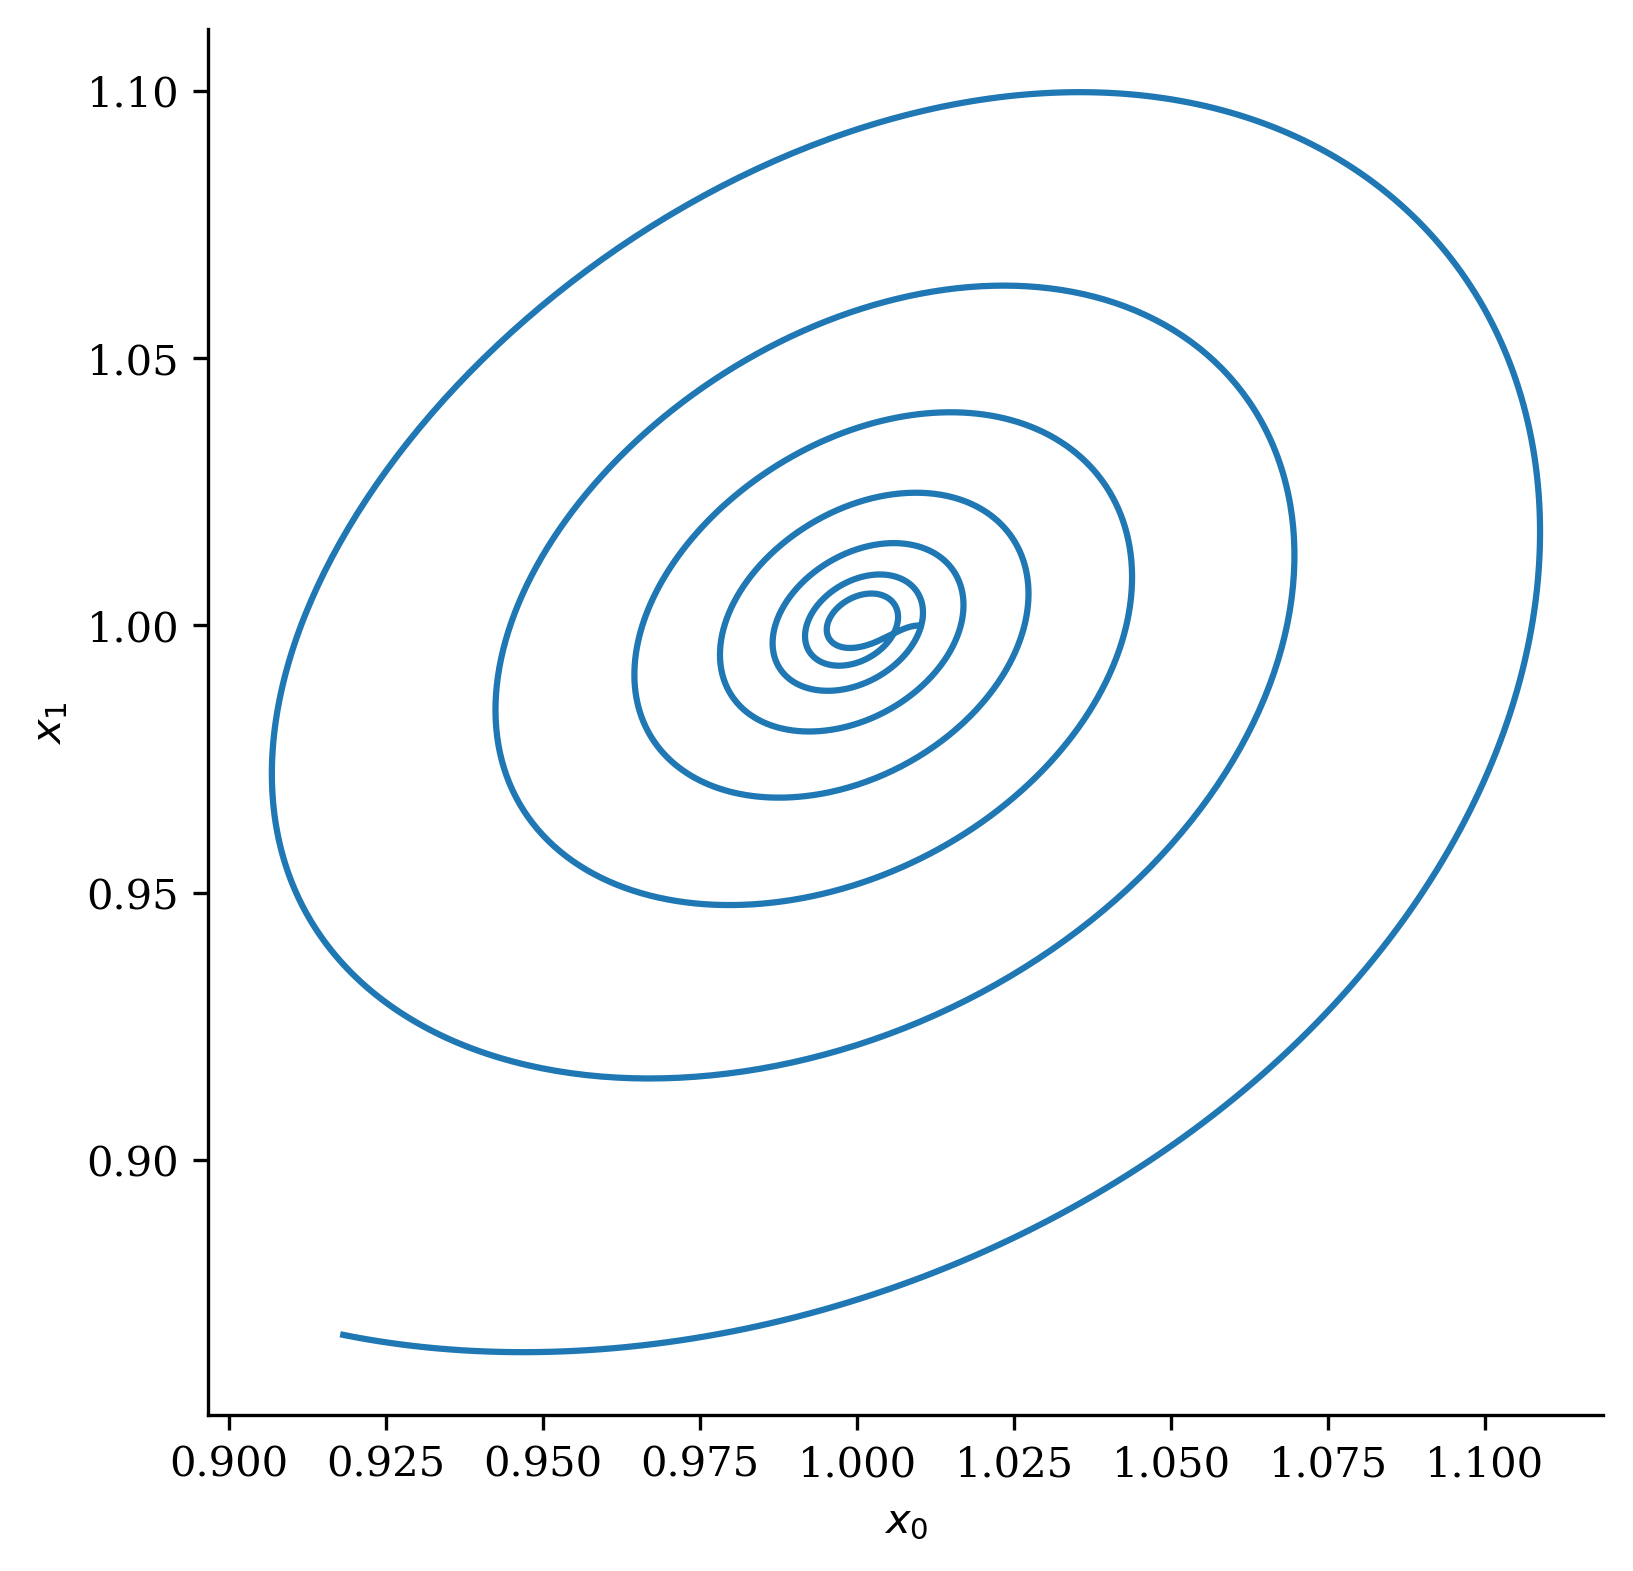

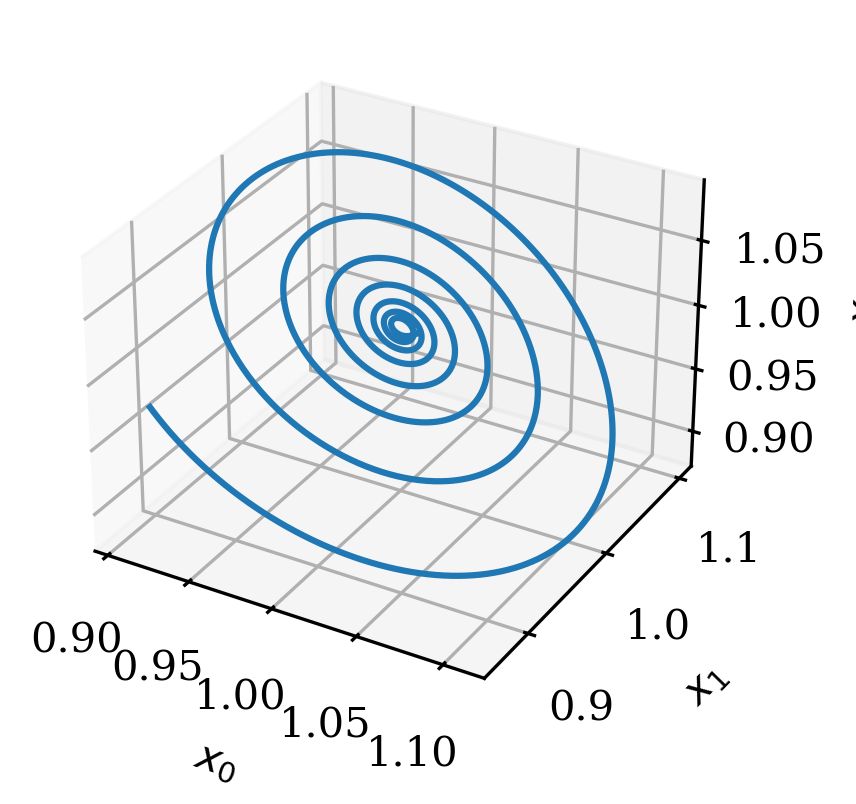

In [4]:
# Inspect data
ind = 0
print(len(states))
print(states[ind].shape)
pl.plot_trajectory_1d(states[ind], times, (0, 1, 2))
pl.plot_trajectory_2d(states[ind], (0, 1))
pl.plot_trajectory_3d(states[ind], (0, 1, 2))

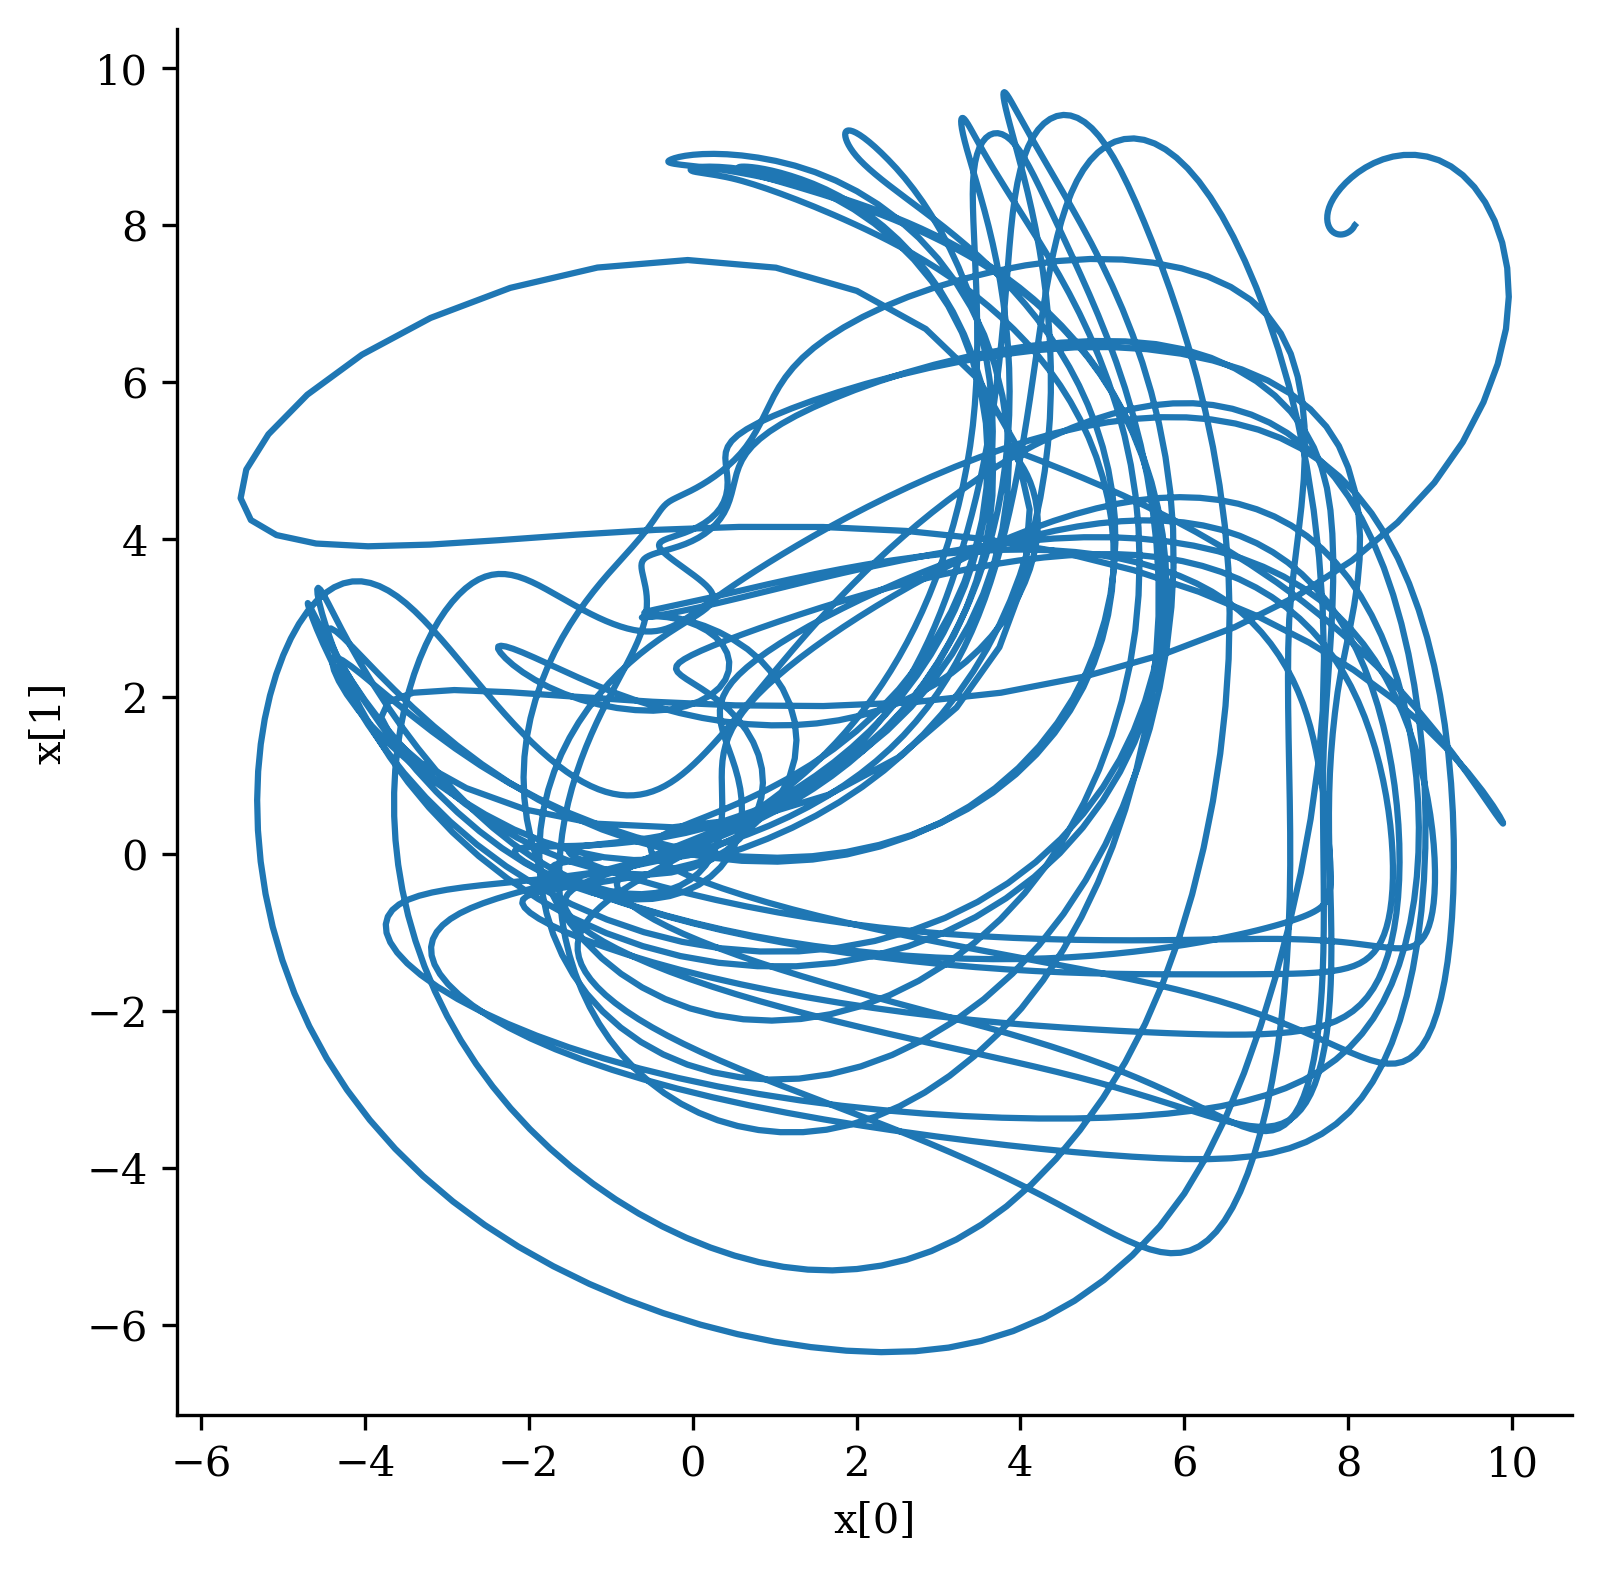

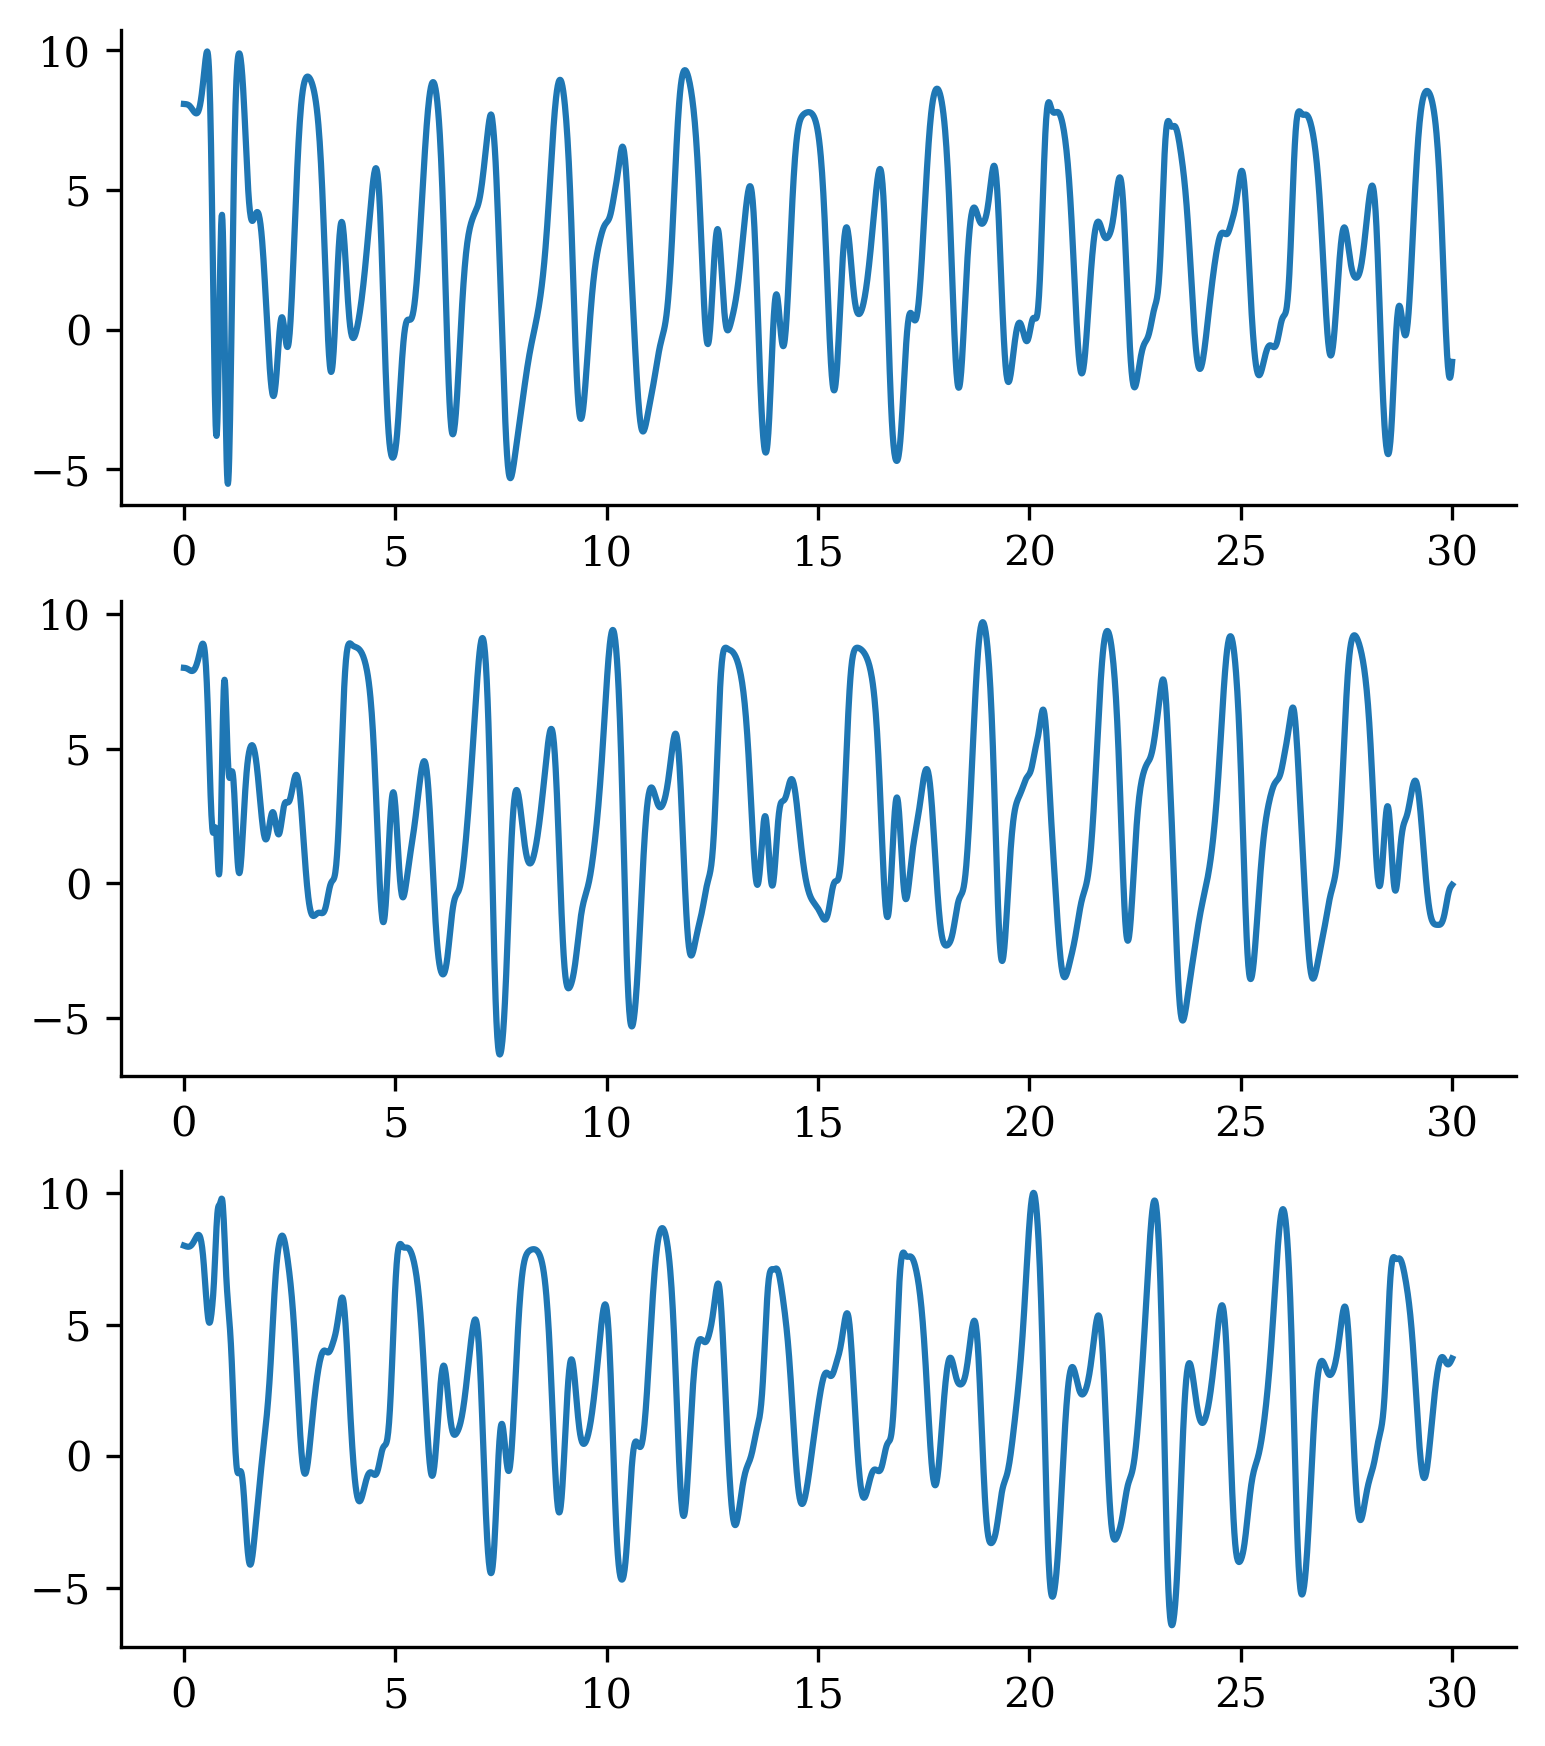

In [12]:
import matplotlib.pyplot as pp
import torch
import torchode as to
import torch.nn as nn

class G(nn.Module):
    '''
    The G class gives the evolution in latent space.
        
        g(z:t)_i = C_i  + A_ij * z_j(t) + B_ijk * z_j(t) * z_k(t)
        with einstein summation.
        
            Here 
                - z(t) are the encoded species + physical parameters
                - C is a vector with adjustable/trainable elements (1D), constant term
                - A is a matrix with adjustable/trainable elements (2D)
                - B is a tensor with adjustable/trainable elements (3D)
    '''
    def __init__(self, z_dim):
        '''
        Initialising the tensors C, A and B.
        '''
        super(G, self).__init__()
        self.C = nn.Parameter(torch.randn(z_dim).requires_grad_(True))
        self.A = nn.Parameter(torch.randn(z_dim, z_dim).requires_grad_(True))
        self.B = nn.Parameter(torch.randn(z_dim, z_dim, z_dim).requires_grad_(True))

    def forward(self, t, z, F):     ## t has also be given to the forward function, in order that the ODE solver can read it properly
        '''
        Forward function of the G class, einstein summations over indices.
        '''
        return self.C + torch.einsum("ij, bj -> bi", self.A, z) + torch.einsum("ijk, bj, bk -> bi", self.B, z, z) + F[:, None]  ## b is the index of the batchsize

class Gnn(nn.Module):
    def __init__(self, n_features, n_hidden):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, n_features)
        )
    def forward(self, t, x, F):
        # x = x.double()
        return self.layers(x.float())
        

def f(t, x, F):
    """Lorenz 96 model with constant forcing (F)."""
    return (torch.from_numpy(np.roll(x, -1)) - torch.from_numpy(np.roll(x, 2))) * torch.from_numpy(np.roll(x, 1)) - x + F[:, None]


# Inputs
seed = 42
state_dimension = 5
F = 8.0
perturbation_scale = 0.01
T = 30
dt = 0.01

# model = G(z_dim=state_dimension)
model = Gnn(n_features=5, n_hidden=32)

# Initial condition
y0 = F * np.ones(state_dimension)

# Perturb equilibrium
rng = np.random.default_rng(seed=seed)
perturbation_index = rng.integers(0, state_dimension, size=1)
perturbation = perturbation_scale * F
y0[perturbation_index] += perturbation

y0 = torch.from_numpy(y0.reshape((1, -1)))

# Time
n_steps = T * int(1/dt)
t_eval = torch.stack((torch.linspace(0, T, n_steps),))

# Forcing
F = torch.tensor([F])

# TorchODE
term = to.ODETerm(f, with_args=True)
# term = to.ODETerm(model, with_args=True)
step_method = to.Dopri5(term=term)
step_size_controller = to.IntegralController(atol=1e-6, rtol=1e-3, term=term)
solver = to.AutoDiffAdjoint(step_method, step_size_controller)
jit_solver = torch.compile(solver)
problem = to.InitialValueProblem(y0=y0, t_eval=t_eval)
sol = jit_solver.solve(problem, args=F)
Y = sol.ys[0].T

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(Y[0,:], Y[1,:])
ax.set_xlabel("x[0]")
ax.set_ylabel("x[1]")
plt.show()

fig, ax = plt.subplots(3, 1, figsize=(6, 1+3*2))
ax[0].plot(t_eval.squeeze(), Y[0,:])
ax[1].plot(t_eval.squeeze(), Y[1,:])
ax[2].plot(t_eval.squeeze(), Y[2,:])
plt.show()